Prepare solution to build ticketing system there by using json file as your primary datasource (Text corpus with other metadata in it). 
1.  Group data into five categories namely Banking services, loans, Fraudalent reporting, Card, others.
2. From step 1 create labeled dataset and utilize it to train supervised model like logistic regression, decision tree or random forest.


Above excercise should follow these steps -
1. Load Data
2. Text Preprocessing
3. EDA
4. Feature Extraction
5. Topic Modelling (Unsupervised)
6. Model building using Supervised learning
7. Model Training and evaluation
8. Inference

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, string

In [2]:
import json

# Loading Data

In [3]:
f = open('Client_data.json')

In [4]:
data = json.load(f)

In [5]:
dataset = pd.json_normalize(data)
dataset.head(5)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [7]:
dataset['_source.complaint_what_happened'] = dataset['_source.complaint_what_happened'].astype(str)

In [8]:
dataset['_source.product'] = dataset['_source.product'].astype(str)

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [10]:
df = dataset[['_source.complaint_what_happened', '_source.product']]
df.head()

,_source.complaint_what_happened,_source.product
0,,Debt collection
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card
3,,Mortgage
4,,Credit card or prepaid card


In [11]:
df.isnull().sum()

_source.complaint_what_happened    0
_source.product                    0
dtype: int64

In [12]:
df.shape

(78313, 2)

# Text Preprocessing

In [13]:
df.rename(columns = {'_source.complaint_what_happened':'Complaint', '_source.product':'Product',
                              }, inplace = True)

C:\Users\tanmay_das1\AppData\Local\Temp\ipykernel_27288\1908717928.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns = {'_source.complaint_what_happened':'Complaint', '_source.product':'Product',


In [14]:
df.head()

,Complaint,Product
0,,Debt collection
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card
3,,Mortgage
4,,Credit card or prepaid card


In [15]:
df[df.loc[:, 'Complaint'] == ''] = np.nan

C:\Users\tanmay_das1\AppData\Local\Temp\ipykernel_27288\1784094937.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.loc[:, 'Complaint'] == ''] = np.nan
C:\Users\tanmay_das1\AppData\Local\Temp\ipykernel_27288\1784094937.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.loc[:, 'Complaint'] == ''] = np.nan


In [16]:
df = df[~df['Complaint'].isnull()]

In [17]:
df.shape

(21072, 2)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Complaint  21072 non-null  object
 1   Product    21072 non-null  object
dtypes: object(2)
memory usage: 493.9+ KB


In [19]:
#df['Product'].unique()

In [20]:
# Lowercasing Complaints
df['Complaint'] = df['Complaint'].str.lower()
df.head()

,Complaint,Product
1,good morning my name is xxxx xxxx and i apprec...,Debt collection
2,i upgraded my xxxx xxxx card in xx/xx/2018 and...,Credit card or prepaid card
10,chase card was reported on xx/xx/2019. however...,"Credit reporting, credit repair services, or o..."
11,"on xx/xx/2018, while trying to book a xxxx xx...","Credit reporting, credit repair services, or o..."
14,my grand son give me check for {$1600.00} i de...,Checking or savings account


In [21]:
# Lowercasing Product
df['Product'] = df['Product'].str.lower()
df.head()

,Complaint,Product
1,good morning my name is xxxx xxxx and i apprec...,debt collection
2,i upgraded my xxxx xxxx card in xx/xx/2018 and...,credit card or prepaid card
10,chase card was reported on xx/xx/2019. however...,"credit reporting, credit repair services, or o..."
11,"on xx/xx/2018, while trying to book a xxxx xx...","credit reporting, credit repair services, or o..."
14,my grand son give me check for {$1600.00} i de...,checking or savings account


In [22]:
# Removing Punctuations
df['Complaint'] = df['Complaint'].str.replace('[^A-Za-z0-9]+',' ', regex=True)
df.head()

,Complaint,Product
1,good morning my name is xxxx xxxx and i apprec...,debt collection
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,credit card or prepaid card
10,chase card was reported on xx xx 2019 however ...,"credit reporting, credit repair services, or o..."
11,on xx xx 2018 while trying to book a xxxx xxxx...,"credit reporting, credit repair services, or o..."
14,my grand son give me check for 1600 00 i depos...,checking or savings account


In [23]:
from nltk.corpus import stopwords

In [24]:
nltk.download('stopwords')
stopwords = stopwords.words('english')
stopwords.append('xxxx')
stopwords.append('xx')
stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tanmay_das1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [25]:
# Removing Stopwords
df['Complaint'] = df['Complaint'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stopwords))
df['Product'] = df['Product'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stopwords))
df.head()

,Complaint,Product
1,good morning name appreciate could help put st...,debt collection
2,upgraded card 2018 told agent upgrade annivers...,credit card prepaid card
10,chase card reported 2019 however fraudulent ap...,"credit reporting, credit repair services, pers..."
11,2018 trying book ticket came across offer 300 ...,"credit reporting, credit repair services, pers..."
14,grand son give check 1600 00 deposit chase acc...,checking savings account


In [26]:
df = df.sample(6000)

In [27]:
import en_core_web_sm
nlp = en_core_web_sm.load()
nltk.download('wordnet')
def lemmatize_text(text):
    sent = []
    doc = nlp(text)
    for token in doc:
        sent.append(token.lemma_)
    return " ".join(sent)
df['lemmatized_Complaint'] = df['Complaint'].apply(lemmatize_text)
df['lemmatized_Product'] = df['Product'].apply(lemmatize_text)
df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tanmay_das1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Complaint,Product,lemmatized_Complaint,lemmatized_Product
22459,chase bank entered credit reports jpmcb consis...,"credit reporting, credit repair services, pers...",chase bank enter credit report jpmcb consisten...,"credit reporting , credit repair service , per..."
25009,completed application chase bank paid 500 00 m...,mortgage,complete application chase bank pay 500 00 mor...,mortgage
34697,support jp morgan chase credit card refused re...,credit card prepaid card,support jp morgan chase credit card refuse res...,credit card prepay card
76713,chase closed account weekend non business day ...,bank account service,chase close account weekend non business day h...,bank account service
15653,chase card company regarding account sure pers...,credit card prepaid card,chase card company regard account sure person ...,credit card prepay card


# EDA

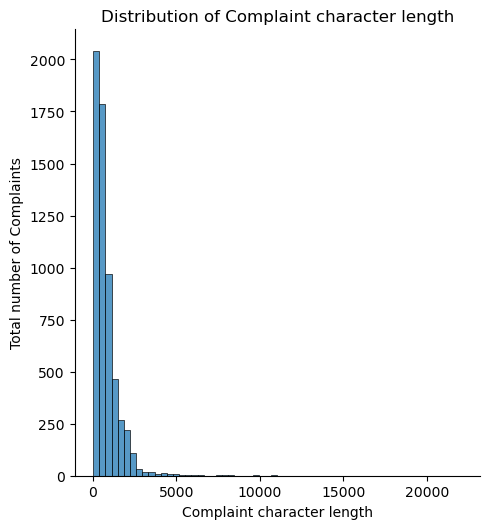

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
char_len = [len(each_sent) for each_sent in df['lemmatized_Complaint']]

sns.displot(char_len, kind='hist', bins=60)
plt.xlabel("Complaint character length")
plt.ylabel("Total number of Complaints")
plt.title("Distribution of Complaint character length")
plt.show()

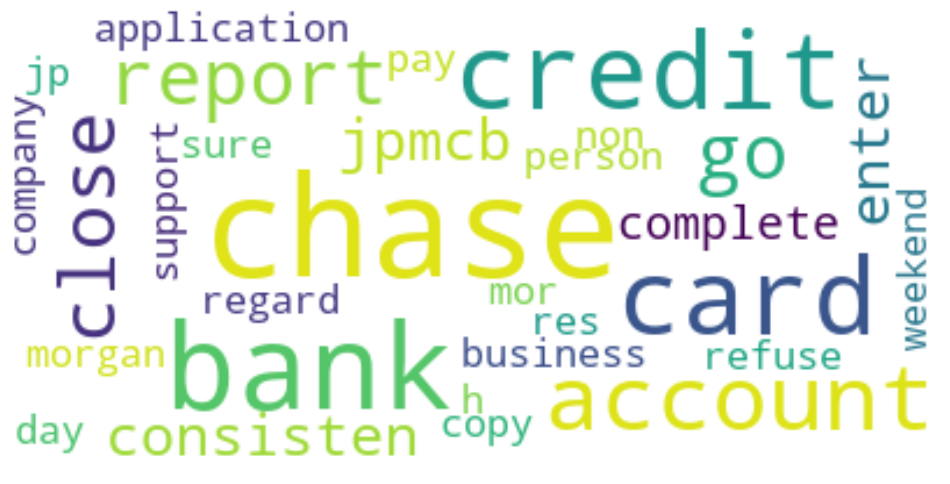

In [29]:
# Wordcloud for complaint
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=30, 
                      background_color="white", random_state=100, 
                      stopwords=stopwords).generate(str(df['lemmatized_Complaint']))
plt.figure(figsize=[12,12])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


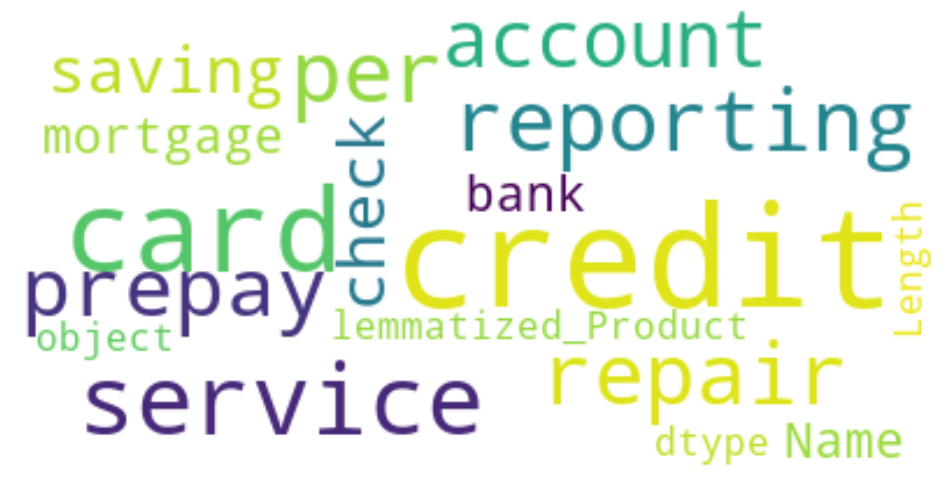

In [30]:
#wordcloud for product
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=30, 
                      background_color="white", random_state=100, 
                      stopwords=stopwords).generate(str(df['lemmatized_Product']))
plt.figure(figsize=[12,12])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Feature Extraction

In [31]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [32]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

In [33]:
dtm = tfidf.fit_transform(df['lemmatized_Complaint'])

In [34]:
dtm

<6000x7520 sparse matrix of type '<class 'numpy.float64'>'
	with 352621 stored elements in Compressed Sparse Row format>

# Topic Modelling (Unsupervised)

In [35]:
from sklearn.decomposition import NMF

In [36]:
#Loading nmf_model with 5 components
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [37]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

D:\Anaconda3\envs\py39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


7520

In [38]:
H = nmf_model.components_       # Topic-term matrix

In [41]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 10)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(10)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:10]
    topic_words.iloc[i] = words[ix]

topic_words

D:\Anaconda3\envs\py39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,account,check,bank,chase,money,deposit,fund,close,open,tell
Topic 2,credit,card,report,inquiry,chase,account,remove,hard,apply,score
Topic 3,loan,mortgage,chase,home,modification,property,letter,send,document,time
Topic 4,charge,card,chase,00,dispute,transaction,purchase,claim,merchant,refund
Topic 5,payment,late,pay,balance,make,fee,00,month,statement,day


In [42]:
#Creating the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)

In [43]:
#Assigning the best topic to each of the complaints in Topic Column
df['Topic'] = topic_results.argmax(axis=1)

In [44]:
df.head()

,Complaint,Product,lemmatized_Complaint,lemmatized_Product,Topic
22459,chase bank entered credit reports jpmcb consis...,"credit reporting, credit repair services, pers...",chase bank enter credit report jpmcb consisten...,"credit reporting , credit repair service , per...",1
25009,completed application chase bank paid 500 00 m...,mortgage,complete application chase bank pay 500 00 mor...,mortgage,2
34697,support jp morgan chase credit card refused re...,credit card prepaid card,support jp morgan chase credit card refuse res...,credit card prepay card,2
76713,chase closed account weekend non business day ...,bank account service,chase close account weekend non business day h...,bank account service,0
15653,chase card company regarding account sure pers...,credit card prepaid card,chase card company regard account sure person ...,credit card prepay card,1


In [45]:
# Printing values in order of the topics
df.sort_values('Topic')

,Complaint,Product,lemmatized_Complaint,lemmatized_Product,Topic
57604,chase charged extended overdraft fee two times...,checking savings account,chase charge extended overdraft fee two time a...,check saving account,0
70065,open account chase bank nevada 10000 00 saving...,bank account service,open account chase bank nevada 10000 00 save s...,bank account service,0
70680,account overdrawn overdraft protection surpris...,bank account service,account overdraw overdraft protection surprise...,bank account service,0
24259,2020 went chase branch location deposited cash...,checking savings account,2020 go chase branch location deposit cashier ...,check saving account,0
28360,fraudulent account opened name,"credit reporting, credit repair services, pers...",fraudulent account open name,"credit reporting , credit repair service , per...",0
...,...,...,...,...,...
49430,made payment tuition university payment portal...,credit card,make payment tuition university payment portal...,credit card,4
10757,2019 called chase credit card company tell pay...,credit card prepaid card,2019 call chase credit card company tell payme...,credit card prepay card,4
55701,every month make credit card autoloan payments...,credit card prepaid card,every month make credit card autoloan payment ...,credit card prepay card,4
19530,lease chase bank coming end decided purchase c...,vehicle loan lease,lease chase bank come end decide purchase car ...,vehicle loan lease,4


In [46]:
#Create the dictionary of Topic names and Topics
Topic_names = { 0:"Banking services", 1:"Card", 2:"others", 3:"Fraudalent reporting", 4:"loans" }

#Replace Topics with Topic Names
df['Topic'] = df['Topic'].map(Topic_names)

In [47]:
df.shape

(6000, 5)

In [48]:
df.head()

,Complaint,Product,lemmatized_Complaint,lemmatized_Product,Topic
22459,chase bank entered credit reports jpmcb consis...,"credit reporting, credit repair services, pers...",chase bank enter credit report jpmcb consisten...,"credit reporting , credit repair service , per...",Card
25009,completed application chase bank paid 500 00 m...,mortgage,complete application chase bank pay 500 00 mor...,mortgage,others
34697,support jp morgan chase credit card refused re...,credit card prepaid card,support jp morgan chase credit card refuse res...,credit card prepay card,others
76713,chase closed account weekend non business day ...,bank account service,chase close account weekend non business day h...,bank account service,Banking services
15653,chase card company regarding account sure pers...,credit card prepaid card,chase card company regard account sure person ...,credit card prepay card,Card


# Model building using Supervised learning

We are now on the verge of building the model, for that we need to convert the topic names to numbers

In [49]:
# Again creating dictionary of Topic names and Topics
Topic_names = { "Banking services":0, "Card":1, "others":2, "Fraudalent reporting":3, "loans":4 }

# Replace Topics with Topic Names
df['Topic'] = df['Topic'].map(Topic_names)

In [50]:
training_data = df[['Complaint', 'Topic']]

In [51]:
training_data

,Complaint,Topic
22459,chase bank entered credit reports jpmcb consis...,1
25009,completed application chase bank paid 500 00 m...,2
34697,support jp morgan chase credit card refused re...,2
76713,chase closed account weekend non business day ...,0
15653,chase card company regarding account sure pers...,1
...,...,...
69742,copy letter sent chase bank dear chase bank cu...,0
15569,run hard credit inquiries account authorized c...,1
21624,know chasebank close card sick go bank,1
24834,tuesday 2020 scammed money called scammer pose...,0


Now, Applying supervised models on the training data created

In [52]:
# code for getting the Vector count

vect = CountVectorizer()
X_train_cnt = vect.fit_transform(training_data['Complaint'])

In [53]:
# code here for transforming the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)

# Model Training and evaluation

### Random Forest Classifier

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)

In [56]:
rf = RandomForestClassifier(random_state=42)

In [57]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [58]:
# Getting accuracy of the model
rf.score(X_test, y_test)

0.8426666666666667

In [59]:
# Making predictions on test data
y_pred = rf.predict(X_test)

In [60]:
# Printing Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[283   4   6  24   0]
 [ 12 256   5  19   2]
 [ 22  16 245  11   1]
 [ 16   5   4 384   1]
 [ 14  15  25  34  96]]


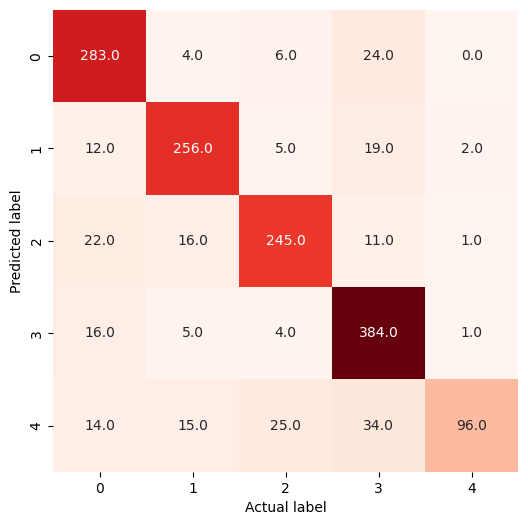

In [61]:
# Visualizing Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="Reds", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [62]:
Topic_Names_target = ["Banking services", "Card", "others", "Fraudalent reporting", "loans"]

In [63]:
# Classification report
print(classification_report(y_test, y_pred, target_names = Topic_Names_target))

                      precision    recall  f1-score   support

    Banking services       0.82      0.89      0.85       317
                Card       0.86      0.87      0.87       294
              others       0.86      0.83      0.84       295
Fraudalent reporting       0.81      0.94      0.87       410
               loans       0.96      0.52      0.68       184

            accuracy                           0.84      1500
           macro avg       0.86      0.81      0.82      1500
        weighted avg       0.85      0.84      0.84      1500



# Inference

According to the above implemented algorithm, accuracy of the model is 84%, and its precision and recall, both are 86% and 81% respectively